# ⚡ Импорт библиотек + фиксация seed⚡

In [15]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from tqdm import tqdm
import numpy as np
import time
import matplotlib.pyplot as plt
import scipy.signal

In [16]:
import numpy as np
import random
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision

random.seed(42)

np.random.seed(42)

torch.manual_seed(42)
torch.cuda.manual_seed(42)
torch.cuda.manual_seed_all(42)

# 🔍 Подготовка данных MNIST для обучения 🔍

In [17]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)) # нормализация по среднему и стд MNIST
])

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

In [18]:
X_train = train_dataset.data.numpy().astype(np.float32) / 255.0
X_train = X_train[:, np.newaxis, :, :] # Добавляем ось для каналов: (60000, 1, 28, 28)
y_train = train_dataset.targets.numpy()

X_test = test_dataset.data.numpy().astype(np.float32) / 255.0
X_test = X_test[:, np.newaxis, :, :] # Добавляем ось для каналов: (10000, 1, 28, 28)
y_test = test_dataset.targets.numpy()

# Преобразуем метки в one-hot encoding, как ожидает ClassNLLCriterion
def to_one_hot(labels, num_classes):
    one_hot = np.zeros((labels.shape[0], num_classes))
    one_hot[np.arange(labels.shape[0]), labels] = 1
    return one_hot

y_train_onehot = to_one_hot(y_train, 10)
y_test_onehot = to_one_hot(y_test, 10)

print(f"Размер тренировочных данных: {X_train.shape}")
print(f"Размер тренировочных меток (one-hot): {y_train_onehot.shape}")
print(f"Размер тестовых данных: {X_test.shape}")
print(f"Размер тестовых меток (one-hot): {y_test_onehot.shape}")

Размер тренировочных данных: (60000, 1, 28, 28)
Размер тренировочных меток (one-hot): (60000, 10)
Размер тестовых данных: (10000, 1, 28, 28)
Размер тестовых меток (one-hot): (10000, 10)


# 🧠 Архитектура рукописной сверточной нейронной сети 🧠

In [25]:
%run modules.ipynb

In [20]:
model = Sequential()
model.add(Conv2d(in_channels=1, out_channels=8, kernel_size=3))
model.add(ReLU())
model.add(BatchNormalization())
model.add(ChannelwiseScaling(n_out=8))

model.add(MaxPool2d(kernel_size=2))
model.add(Dropout(p=0.25)) 

model.add(Conv2d(in_channels=8, out_channels=16, kernel_size=3))
model.add(ReLU())

model.add(MaxPool2d(kernel_size=2))

model.add(Flatten())

model.add(Linear(n_in=16 * 7 * 7, n_out=10))

model.add(LogSoftmax())

print("Структура модели:")
print(model)

Структура модели:
Conv2d 1 -> 8
ReLU
BatchNormalization
ChannelwiseScaling
MaxPool2d, kern 2, stride 2
Dropout
Conv2d 8 -> 16
ReLU
MaxPool2d, kern 2, stride 2
Flatten
Linear 784 -> 10
LogSoftMax



# 🔄 Процесс обучения и оптимизации 🔄


In [21]:
# Определение функции потерь и оптимизатора 
criterion = ClassNLLCriterion()

# Конфигурация для Adam
adam_config = {
    'learning_rate': 0.001,
    'beta1': 0.9,
    'beta2': 0.999,
    'epsilon': 1e-8
}
adam_state = {} # Состояние оптимизатора (для моментов m и v)


epochs = 5
batch_size = 64

In [22]:
train_losses = []
test_accuracies = []

print("Начало обучения...")
for epoch in range(epochs):
    start_time = time.time()
    epoch_loss = 0
    
    # Перемешиваем данные
    permutation = np.random.permutation(X_train.shape[0])
    X_train_shuffled = X_train[permutation]
    y_train_onehot_shuffled = y_train_onehot[permutation]

    # Устанавливаем режим обучения
    model.train()

    for i in range(0, X_train.shape[0], batch_size):
        # Получаем мини-батч
        batch_X = X_train_shuffled[i:i + batch_size]
        batch_y_onehot = y_train_onehot_shuffled[i:i + batch_size]

        # Обнуляем градиенты параметров
        model.zeroGradParameters()

        # Прямой проход
        output = model.forward(batch_X)

        # Вычисление потерь
        loss = criterion.forward(output, batch_y_onehot)
        epoch_loss += loss

        grad_from_loss = criterion.backward(output, batch_y_onehot)
        model.backward(batch_X, grad_from_loss)

        # Получаем параметры и их градиенты
        params = model.getParameters()
        grads = model.getGradParameters()

        # Шаг оптимизации (обновление параметров)
        adam(params, grads, adam_config, adam_state)

        if (i // batch_size) % 100 == 0:
             print(f"  Эпоха {epoch+1}, Батч {i // batch_size}/{X_train.shape[0] // batch_size}: Потери = {loss:.4f}")


    # Средние потери за эпоху
    avg_epoch_loss = epoch_loss / (X_train.shape[0] / batch_size)
    train_losses.append(avg_epoch_loss)

    model.evaluate() # Устанавливаем режим оценки
    
    correct_predictions = 0
    total_samples = 0

    test_output = model.forward(X_test)
    
    # Получаем предсказанные классы (индексы с максимальным логарифмом вероятности)
    predicted_classes = np.argmax(test_output, axis=1)
    
    # Получаем истинные классы из one-hot меток
    true_classes = np.argmax(y_test_onehot, axis=1)

    # Сравниваем предсказанные и истинные классы
    correct_predictions = np.sum(predicted_classes == true_classes)
    total_samples = X_test.shape[0]
    accuracy = correct_predictions / total_samples
    test_accuracies.append(accuracy)

    end_time = time.time()
    epoch_duration = end_time - start_time

    print(f"Эпоха {epoch+1}/{epochs} завершена. Средние потери: {avg_epoch_loss:.4f}, Точность на тесте: {accuracy:.4f}. Время: {epoch_duration:.2f} сек.")

Начало обучения...
  Эпоха 1, Батч 0/937: Потери = 2.6907
  Эпоха 1, Батч 100/937: Потери = 0.3203
  Эпоха 1, Батч 200/937: Потери = 0.2703
  Эпоха 1, Батч 300/937: Потери = 0.4289
  Эпоха 1, Батч 400/937: Потери = 0.4117
  Эпоха 1, Батч 500/937: Потери = 0.1680
  Эпоха 1, Батч 600/937: Потери = 0.2212
  Эпоха 1, Батч 700/937: Потери = 0.1541
  Эпоха 1, Батч 800/937: Потери = 0.0339
  Эпоха 1, Батч 900/937: Потери = 0.0942
Эпоха 1/5 завершена. Средние потери: 0.2647, Точность на тесте: 0.9487. Время: 2047.92 сек.
  Эпоха 2, Батч 0/937: Потери = 0.0766
  Эпоха 2, Батч 100/937: Потери = 0.0404
  Эпоха 2, Батч 200/937: Потери = 0.0579
  Эпоха 2, Батч 300/937: Потери = 0.0334
  Эпоха 2, Батч 400/937: Потери = 0.1675
  Эпоха 2, Батч 500/937: Потери = 0.1168
  Эпоха 2, Батч 600/937: Потери = 0.1123
  Эпоха 2, Батч 700/937: Потери = 0.1238
  Эпоха 2, Батч 800/937: Потери = 0.1020
  Эпоха 2, Батч 900/937: Потери = 0.0611
Эпоха 2/5 завершена. Средние потери: 0.1162, Точность на тесте: 0.9579. В

In [27]:
train_losses_hand = train_losses.copy()
test_accuracies_hand = test_accuracies.copy()

# 🤖 Архитектура сверточной нейронной сети с использованием PyTorch 🤖


In [28]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()

        self.features = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3, padding='same'),
            nn.ReLU(),
            nn.BatchNorm2d(8),
            
            nn.MaxPool2d(kernel_size=2),
            nn.Dropout(0.25),

            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, padding='same'),
            nn.ReLU(),

            nn.MaxPool2d(kernel_size=2, stride=2),

            # nn.Dropout(0.5), # Можно добавить Dropout, если нужно
        )

        self.classifier = nn.Sequential(
            nn.Flatten(), # Преобразует тензор из (Batch, Channels, Height, Width) в (Batch, Channels * Height * Width)
            nn.Linear(in_features=16 * 7 * 7, out_features=10), # Полносвязный слой: 784 входа, 10 выходов (для 10 классов MNIST)
            nn.LogSoftmax(dim=1)
        )

    def forward(self, x):
        # Прямой проход: сначала через сверточные слои, затем через классификатор
        x = self.features(x)
        x = self.classifier(x)
        return x

In [29]:
# --- Создание экземпляра модели, функции потерь и оптимизатора ---
model = SimpleCNN()


criterion = nn.NLLLoss()

# Оптимизатор Adam
optimizer = optim.Adam(model.parameters(), lr=0.001)

# --- Параметры обучения ---
epochs = 5 # Установи количество эпох

# --- Цикл обучения ---
train_losses = []
test_accuracies = []


In [30]:
# Создаем загрузчики данных
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1000, shuffle=False)

# 🔄 Процесс обучения и оптимизации 🔄


In [31]:
device = torch.device('cpu')

# Обучение модели
for epoch in range(epochs):
    start_time = time.time()
    epoch_loss = 0
    
    # Устанавливаем режим обучения
    model.train()

    for batch_idx, (data, target) in enumerate(train_loader):
        # Перемещаем данные и метки на устройство
        data, target = data.to(device), target.to(device)

        # Обнуляем градиенты
        optimizer.zero_grad()

        # Прямой проход
        output = model(data)

        # Вычисление потерь
        loss = criterion(output, target)
        epoch_loss += loss.item()  # .item() извлекает скалярное значение из тензора

        # Обратный проход (вычисление градиентов)
        loss.backward()

        # Шаг оптимизации (обновление параметров)
        optimizer.step()

        # Опционально: вывод прогресса
        if (batch_idx + 1) % 100 == 0:
            print(f"  Эпоха {epoch+1}, Батч {batch_idx+1}/{len(train_loader)}: Потери = {loss.item():.4f}")

    # Средние потери за эпоху
    avg_epoch_loss = epoch_loss / len(train_loader)
    train_losses.append(avg_epoch_loss)

    # --- Оценка на тестовом наборе ---
    model.eval()  # Устанавливаем режим оценки
    test_loss = 0
    correct = 0
    
    # Отключаем вычисление градиентов для экономии памяти и ускорения
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item()  # Суммируем потери по батчам

            # Получаем предсказанный класс (индекс с максимальным логарифмом вероятности)
            pred = output.argmax(dim=1, keepdim=True)
            # Сравниваем предсказания с истинными метками
            correct += pred.eq(target.view_as(pred)).sum().item()

    # Средние потери на тесте
    test_loss /= len(test_loader.dataset)  # Делим на общее количество примеров

    # Точность на тесте
    accuracy = 100.0 * correct / len(test_loader.dataset)
    test_accuracies.append(accuracy / 100.0)

    end_time = time.time()
    epoch_duration = end_time - start_time

    print(f"Эпоха {epoch+1}/{epochs} завершена. Средние потери на трейне: {avg_epoch_loss:.4f}, Точность на тесте: {accuracy:.2f}%. Время: {epoch_duration:.2f} сек.")


  Эпоха 1, Батч 100/938: Потери = 0.4002
  Эпоха 1, Батч 200/938: Потери = 0.4189
  Эпоха 1, Батч 300/938: Потери = 0.2642
  Эпоха 1, Батч 400/938: Потери = 0.0846
  Эпоха 1, Батч 500/938: Потери = 0.1294
  Эпоха 1, Батч 600/938: Потери = 0.0546
  Эпоха 1, Батч 700/938: Потери = 0.1336
  Эпоха 1, Батч 800/938: Потери = 0.0808
  Эпоха 1, Батч 900/938: Потери = 0.2370
Эпоха 1/5 завершена. Средние потери на трейне: 0.2293, Точность на тесте: 97.76%. Время: 8.39 сек.
  Эпоха 2, Батч 100/938: Потери = 0.1101
  Эпоха 2, Батч 200/938: Потери = 0.1592
  Эпоха 2, Батч 300/938: Потери = 0.0268
  Эпоха 2, Батч 400/938: Потери = 0.0214
  Эпоха 2, Батч 500/938: Потери = 0.1871
  Эпоха 2, Батч 600/938: Потери = 0.0616
  Эпоха 2, Батч 700/938: Потери = 0.0354
  Эпоха 2, Батч 800/938: Потери = 0.1907
  Эпоха 2, Батч 900/938: Потери = 0.1543
Эпоха 2/5 завершена. Средние потери на трейне: 0.0922, Точность на тесте: 97.99%. Время: 8.54 сек.
  Эпоха 3, Батч 100/938: Потери = 0.0686
  Эпоха 3, Батч 200/938

# 📈 Графики потерь и точности по эпохам pyTorch vs hand📈


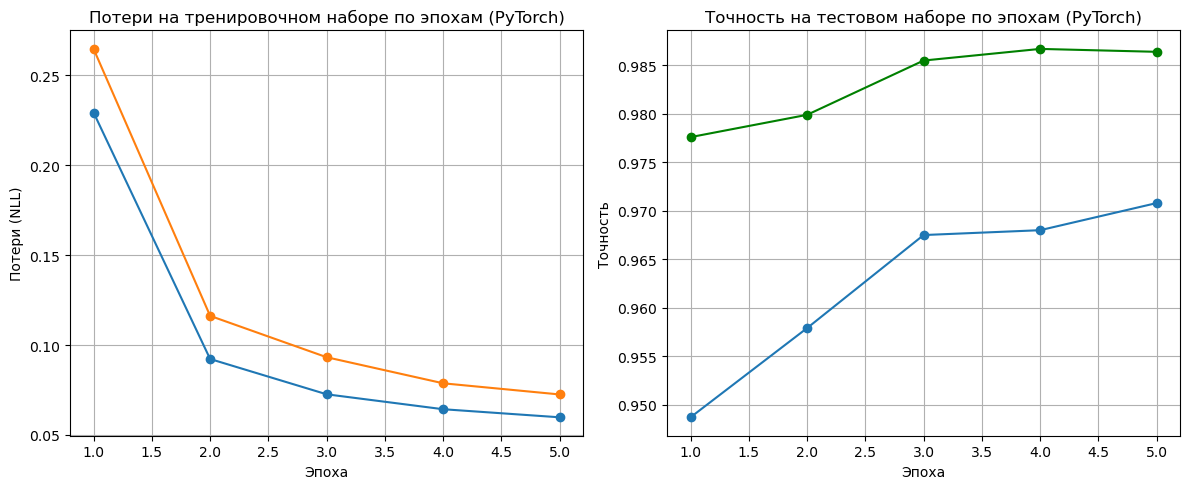

In [32]:
# --- Визуализация результатов ---
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(1, epochs + 1), train_losses, marker='o')
plt.plot(range(1, epochs + 1), train_losses_hand, marker='o')
plt.title('Потери на тренировочном наборе по эпохам (PyTorch)')
plt.xlabel('Эпоха')
plt.ylabel('Потери (NLL)')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(range(1, epochs + 1), test_accuracies, marker='o', color='green')
plt.plot(range(1, epochs + 1), test_accuracies_hand, marker='o')
plt.title('Точность на тестовом наборе по эпохам (PyTorch)')
plt.xlabel('Эпоха')
plt.ylabel('Точность')
plt.grid(True)

plt.tight_layout()
plt.show()